In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import tifffile as tiff 
import pickle
from pathlib import Path
from skimage import io
from tensorflow.keras import backend as K

from datetime import datetime
from deepcell.applications import NuclearSegmentation
from deepcell.applications import CellTracking


### Insert folder to p - all views inside will be analyzed and results will be saved to different folders

In [5]:
tif_path = Path(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\TIF')

In [6]:
def merge_tff(tif_files , seq_length = 0):
    if tif_files:
        tff = tiff.imread(tif_files[0])
        if len(tff.shape) == 2:
            tff = np.expand_dims(tff, axis=-1)
        tff = np.expand_dims(tff, axis=0)
    if tif_files[1:]:
        for other in tif_files[1:]:
            othertff = tiff.imread(other)
            if len(othertff.shape) == 2:
                othertff = np.expand_dims(othertff, axis=-1)
            othertff = np.expand_dims(othertff, axis=0)
            tff = np.concatenate((tff,othertff))

    if seq_length > 0 and seq_length < len(tff):
        tff = tff[0:seq_length,...]
    return tff

In [7]:
def pick_channel(x,channel = 0):
    return x[...,channel:(channel+1)]


In [8]:
def segmentation(x, mpp =2.24):
    app = NuclearSegmentation()
    y_seg = app.predict(x, image_mpp = mpp)
    return y_seg

In [9]:
def tracking(x, y_seg):
    tracker = CellTracking()
    tracked_data = tracker.track(np.copy(x), y_seg)
    return tracked_data

In [10]:
def plot_tff(im1,im2,vmin,vmax):
    fig, ax = plt.subplots(1, 2, figsize=(30, 15))
    ax[0].imshow(im1)
    ax[0].axis('off')
    ax[0].set_title('Raw')
    ax[1].imshow(im2, cmap='jet', vmin=vmin, vmax=vmax)
    ax[1].set_title('Tracked')
    ax[1].axis('off')

    fig.canvas.draw()  # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return image



In [11]:
def save_results(x,y_seg, tracked_data, tff_path,well,view):
    centroids = pd.DataFrame(columns = range(x.shape[0]))
    morphologies = pd.DataFrame(columns = range(x.shape[0]))
    embeddings = pd.DataFrame(columns = range(x.shape[0]))

    for cell_id, cell_dict in tracked_data['tracks'].items():
        for i,frame in enumerate(cell_dict['frames']):
            centroids.at[cell_id,frame] = cell_dict['centroid'][i]
            morphologies.at[cell_id,frame] = cell_dict['morphologies'][i]
            embeddings.at[cell_id,frame] = cell_dict['embedding'][i]

    date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    directory = f"Results_{well}_{view}_{date}"
    res_path = tff_path.joinpath(directory)
    os.mkdir(res_path)

    centroids.to_csv(res_path.joinpath('centroids.csv'))
    morphologies.to_csv(res_path.joinpath('morphologies.csv'))
    embeddings.to_csv(res_path.joinpath('embeddings.csv'))

    with open(res_path.joinpath('track_results.pkl'), 'wb') as f:
        pickle.dump(tracked_data, f)

    X = tracked_data['X']  # raw X data
    y = tracked_data['y_tracked']  # tracked y data

    imageio.mimsave(res_path.joinpath('tracks.tif'), [plot_tff(x[i,...,0], y[i,...,0], y.min(), y.max())
                                for i in range(y_seg.shape[0])])
    
    imageio.mimsave(res_path.joinpath('tracks.gif'), [plot_tff(x[i,...,0], y[i,...,0], y.min(), y.max())
                            for i in range(y_seg.shape[0])])
                                

In [12]:
tif_files = list(tif_path.glob('*.tif'))
well_dict = {}
for tif_file in tif_files:
    file_name = tif_file.stem.split('_')
    well_name = file_name[2]
    view_name = file_name[3]
    
    if well_name not in well_dict:
        well_dict[well_name] = {}
    if view_name not in well_dict[well_name]:
        well_dict[well_name][view_name] = []

    well_dict[well_name][view_name].append(tif_file)

for well, views in well_dict.items():
    for view , view_tif in views.items():
        print(f'well:{well} , view:{view}, {len(view_tif)}')

well:D2 , view:1, 95
well:D2 , view:2, 95
well:D2 , view:3, 95
well:D2 , view:4, 95
well:D3 , view:1, 95
well:D3 , view:2, 95
well:D3 , view:3, 95
well:D3 , view:4, 95
well:D4 , view:1, 95
well:D4 , view:2, 95
well:D4 , view:3, 95
well:D4 , view:4, 95
well:D5 , view:1, 95
well:D5 , view:2, 95
well:D5 , view:3, 95
well:D5 , view:4, 95
well:D6 , view:1, 95
well:D6 , view:2, 95
well:D6 , view:3, 95
well:D6 , view:4, 95
well:D7 , view:1, 95
well:D7 , view:2, 95
well:D7 , view:3, 95
well:D7 , view:4, 95
well:E10 , view:1, 95
well:E10 , view:2, 95
well:E10 , view:3, 95
well:E10 , view:4, 95
well:E2 , view:1, 95
well:E2 , view:2, 95
well:E2 , view:3, 95
well:E2 , view:4, 95
well:E3 , view:1, 95
well:E3 , view:2, 95
well:E3 , view:3, 95
well:E3 , view:4, 95
well:E4 , view:1, 95
well:E4 , view:2, 95
well:E4 , view:3, 95
well:E4 , view:4, 95
well:E5 , view:1, 95
well:E5 , view:2, 95
well:E5 , view:3, 95
well:E5 , view:4, 95
well:E6 , view:1, 95
well:E6 , view:2, 95
well:E6 , view:3, 95
well:E6 ,

In [33]:
for well, views in well_dict.items():
    for view , view_tif in views.items():
        if well != 'D2' or int(view) != 1:
            continue
        print(f'well:{well} , view:{view}, {len(view_tif)}')
        merged_tff = merge_tff(view_tif,seq_length=10)
        merged_tff = merged_tff[4:,...]
        # tff = pick_channel(tff,0)
        print("Segmentation")
        seg_tff = segmentation(merged_tff, mpp=0.65) #2.24
        print("Tracking")
        track_tff = tracking(merged_tff,seg_tff)
        save_results(merged_tff,seg_tff,track_tff,tif_path,well,view)

well:D2 , view:1, 95
Segmentation


c:\Projects\TAU\DL-Workshop\deepcell-modified\deepcell-tf\Enviroments\deepcell_mod\lib\site-packages\deepcell_toolbox\deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


Tracking


c:\Projects\TAU\DL-Workshop\deepcell-modified\deepcell-tf\Enviroments\deepcell_mod\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['current_morphologiess', 'future_morphologiess'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
track_tff = tracking(merged_tff,seg_tff)

ValueError: need at least one array to stack

In [32]:
merged_tff[2:,...].shape

(1, 1040, 1408, 1)

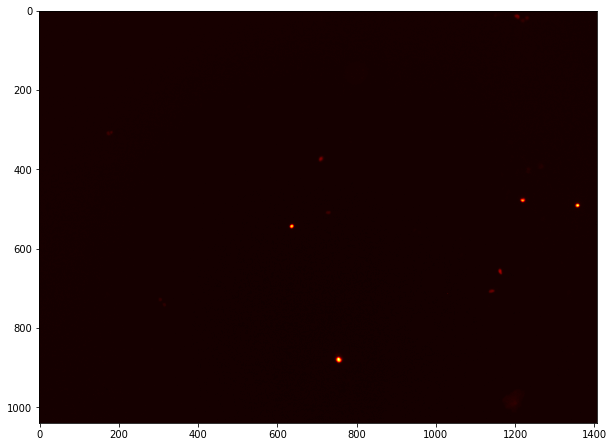

In [29]:
tff = tiff.imread(view_tif[])
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(tff, cmap=plt.cm.hot)
plt.show()

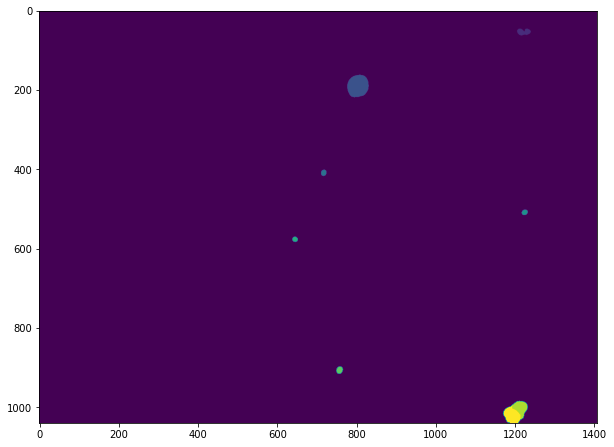

In [25]:
fig, ax = plt.subplots( figsize=(10, 10))
ax.imshow(seg_tff[1,...,0])
plt.show()

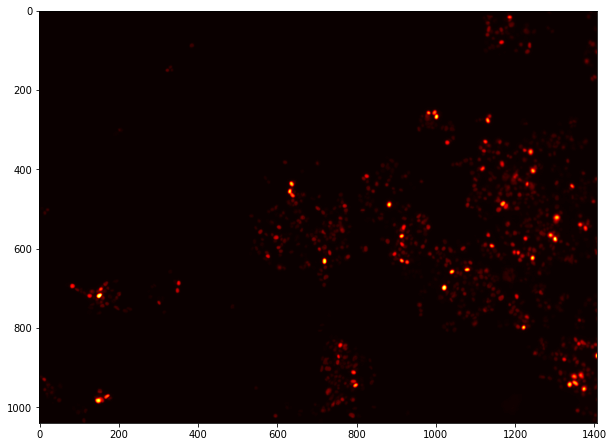

In [34]:
tff = tiff.imread(view_tif[i])
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(tff, cmap=plt.cm.hot)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(tff)
plt.show()